In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#必要なライブラリーをインストール
!pip install keras
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 8.6 MB/s eta 0:00:00


In [3]:
#必要なライブラリーをインポート
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# #lstm
# from keras.layers import LSTM
# from keras.callbacks import EarlyStopping
# from keras.optimizers import Adam

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
#csvファイルを読み込み
# working_dir = "/content/drive/MyDrive/ゼミ/公開ソース"
working_dir = "/content/drive/MyDrive/公開ソース"
path = f'{working_dir}/data/traninig_validation_test_data'
city_lists = ["Tokyo","Delhi"]

for city_name in city_lists:
  city_df = pd.read_csv(f'{path}/{city_name}_paper.csv',index_col=0,parse_dates=True)
  exec("{}=city_df".format(city_name))

In [5]:
#目的変数を抽出するためのリスト
# elements = ["AQI_total","pm25","pm10","co","no2","so2","o3"]
elements = ["AQI_total"]
# elements = ["co","no2","so2","o3"]

In [6]:
#学習用データ作成
def make_sequences(sequences,n_steps_in,n_steps_out):
  X = []
  y = []
  for i in range(0, len(sequences), 1):
    end_num = i + n_steps_in + 1 # 学習用の最後
    out_end_num = end_num + n_steps_out -1

    if out_end_num > len(sequences):
      break

    x_seq = sequences[i:end_num-1, :]
    y_seq = sequences[end_num-1:out_end_num, -1]

    X.append(x_seq)
    y.append(y_seq)

  return np.array(X), np.array(y)

In [7]:
#MAPE値を算出するための関数
def mape(predict, observed):
  absolute_diff_percentage =  abs( (predict - observed) / observed)
  sum_abs_diff = sum(absolute_diff_percentage)
  mape = sum_abs_diff / len(predict)

  return mape

In [8]:
#MAPE値を保存するためのデータフレームを作成
df_results = pd.DataFrame(columns=["cnn_week_mape"])

In [9]:
#1週間単位の予測値を保存するデータフレーム作成
#データフレームの列の長さは
Tokyo_week = Tokyo.resample("W").mean()
df_pred_week =  pd.DataFrame(index=[Tokyo_week.index])[-48:]

# CNNの練習ゾーン


In [ ]:
def create_cnn_model(df,city_name):
  df_pred_data = pd.DataFrame(columns=[])
  for element in elements:
    df_w = df.resample("W").mean()
    rh_min = df_w[element].min()
    rh_max = df_w[element].max()
    df_w["target"] = (df_w[element] - rh_min) / (rh_max - rh_min)
    df_target = df_w[["target"]]
    df_train = df_target[:-104]
    df_val = df_target[-104:-52]
    df_test = df_target[-52:]
    #学習データの作成
    dataset_train = df_train.dropna().values
    dataset_val = df_val.dropna().values
    dataset_test = df_test.dropna().values
    #約一ヶ月(4つ)の値から1週間の値を出力
    n_steps_in = 4
    n_steps_out = 1
    X_train,y_train = make_sequences(dataset_train,n_steps_in,n_steps_out)
    X_val,y_val = make_sequences(dataset_val,n_steps_in,n_steps_out)
    X_test,y_test = make_sequences(dataset_test,n_steps_in,n_steps_out)

    n_features = X_train.shape[2]
    n_timessteps = X_train.shape[1]
    n_outputs = y_train.shape[1]

    model = Sequential()

    conv_filters = trial.suggest_int('conv_filters', 16, 64)
    kernel_size = trial.suggest_int('kernel_size', 1, 2)
    dense_units = trial.suggest_int('dense_units', 32, 100)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)

    model.add(Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu', input_shape=(n_steps_in, n_features)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(units=dense_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1, activation='linear'))

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    model.summary()
    epochs=100
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=32, verbose=0)
    plt.plot(range(epochs), history.history['loss'], label='loss')
    plt.plot(range(epochs), history.history['val_loss'], label='val_loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()




    # def objective_cnn(trial, X_train, y_train, X_val, y_val):
    #   # input_shape = X_train.shape[1:]
    #   model = create_cnn_week_model(trial)
    #   early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    #   epochs=100
    #   history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=32,callbacks=[early_stopping], verbose=0)

    #   y_val_pred = model.predict(X_val)
    #   val_mse = mean_squared_error(y_val, y_val_pred)

    #   return val_mse

    # Optunaでハイパーパラメータの最適化（訓練データと検証データを使用）
    # study = optuna.create_study(direction='minimize')
    # study.optimize(lambda trial: objective_cnn(trial, X_train, y_train, X_val, y_val), n_trials=10)


In [30]:
#CNNの学習をグラフで読み解く
def create_cnn_project(df,city_name):
  df_pred_data = pd.DataFrame(columns=[])
  for element in elements:
    df_w = df.resample("W").mean()
    rh_min = df_w[element].min()
    rh_max = df_w[element].max()
    df_w["target"] = (df_w[element] - rh_min) / (rh_max - rh_min)
    df_target = df_w[["target"]]
    df_train = df_target[:-104]
    df_val = df_target[-104:-52]
    df_test = df_target[-52:]
    #学習データの作成
    dataset_train = df_train.dropna().values
    dataset_val = df_val.dropna().values
    dataset_test = df_test.dropna().values
    #約一ヶ月(4つ)の値から1週間の値を出力
    n_steps_in = 4
    n_steps_out = 1
    X_train,y_train = make_sequences(dataset_train,n_steps_in,n_steps_out)
    X_val,y_val = make_sequences(dataset_val,n_steps_in,n_steps_out)
    X_test,y_test = make_sequences(dataset_test,n_steps_in,n_steps_out)

    n_features = X_train.shape[2]
    n_timessteps = X_train.shape[1]
    n_outputs = y_train.shape[1]

    model = Sequential()
    model.add(Conv1D(68, 8, padding="same", input_shape=(n_steps_in, n_features), activation="relu"))
    model.add(MaxPooling1D(2, padding="same"))
    model.add(Conv1D(64, 8, padding="same", activation="relu"))
    model.add(MaxPooling1D(2, padding="same"))
    model.add(Conv1D(32, 8, padding='same', activation='relu'))
    model.add(Conv1D(1, 8, padding='same', activation='tanh'))

    model.compile(loss='mse', optimizer='adam')
    model.summary()
    epochs = 100
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),validation_split=0.1, epochs=epochs)
    plt.plot(range(epochs), history.history['loss'], label='loss')
    plt.plot(range(epochs), history.history['val_loss'], label='val_loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

    y_val_pred = model.predict(X_val)
    val_mse = mean_squared_error(y_val, y_val_pred)

    # mape_df = str(str(round(mape(y_val_pred, y_val)*100,2))+"%")

    # return mape_df


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_35 (Conv1D)          (None, 4, 68)             612       
                                                                 
 max_pooling1d_19 (MaxPooli  (None, 2, 68)             0         
 ng1D)                                                           
                                                                 
 conv1d_36 (Conv1D)          (None, 2, 64)             34880     
                                                                 
 max_pooling1d_20 (MaxPooli  (None, 1, 64)             0         
 ng1D)                                                           
                                                                 
 conv1d_37 (Conv1D)          (None, 1, 32)             16416     
                                                                 
 conv1d_38 (Conv1D)          (None, 1, 1)            

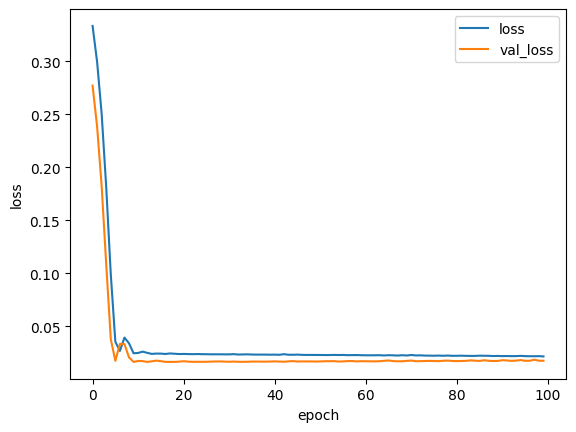

2/2 [==============================] - 0s 5ms/step


ValueError: Found array with dim 3. None expected <= 2.

In [31]:
create_cnn_project(Tokyo,"Tokyo")

In [ ]:
def create_cnn_model(df,city_name):
  df_pred_data = pd.DataFrame(columns=[])
  for element in elements:
    df_w = df.resample("W").mean()
    rh_min = df_w[element].min()
    rh_max = df_w[element].max()
    df_w["target"] = (df_w[element] - rh_min) / (rh_max - rh_min)
    df_target = df_w[["target"]]
    df_train = df_target[:-104]
    df_val = df_target[-104:-52]
    df_test = df_target[-52:]
    #学習データの作成
    dataset_train = df_train.dropna().values
    dataset_val = df_val.dropna().values
    dataset_test = df_test.dropna().values
    #約一ヶ月(4つ)の値から1週間の値を出力
    n_steps_in = 4
    n_steps_out = 1
    X_train,y_train = make_sequences(dataset_train,n_steps_in,n_steps_out)
    X_val,y_val = make_sequences(dataset_val,n_steps_in,n_steps_out)
    X_test,y_test = make_sequences(dataset_test,n_steps_in,n_steps_out)

    n_features = X_train.shape[2]
    n_timessteps = X_train.shape[1]
    n_outputs = y_train.shape[1]
    def create_cnn_week_model(trial):
      model = Sequential()

      conv_filters = trial.suggest_int('conv_filters', 16, 64)
      kernel_size = trial.suggest_int('kernel_size', 1, 2)
      dense_units = trial.suggest_int('dense_units', 32, 100)
      dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)

      model.add(Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu', input_shape=(n_steps_in, n_features)))
      model.add(MaxPooling1D(pool_size=2))
      model.add(Flatten())
      model.add(Dense(units=dense_units, activation='relu'))
      model.add(Dropout(dropout_rate))
      model.add(Dense(units=1, activation='linear'))

      model.compile(optimizer='adam', loss='mse', metrics=['mae'])
      model.summary()
      return model



    def objective_cnn(trial, X_train, y_train, X_val, y_val):
      # input_shape = X_train.shape[1:]
      model = create_cnn_week_model(trial)
      early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
      epochs=100
      history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=32,callbacks=[early_stopping], verbose=0)

      y_val_pred = model.predict(X_val)
      val_mse = mean_squared_error(y_val, y_val_pred)

      return val_mse

      # Optunaでハイパーパラメータの最適化（訓練データと検証データを使用）
      study = optuna.create_study(direction='minimize')
      study.optimize(lambda trial: objective_cnn(trial, X_train, y_train, X_val, y_val), n_trials=10)

      # 最適なハイパーパラメータの取得
      best_params = study.best_params
      print("Best Hyperparameters:", best_params)

      optimal_model = create_cnn_week_model(study.best_trial)
      early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
      optimal_model.fit(X_train, y_train, epochs=10, batch_size=32, callbacks=[early_stopping],verbose=1)

      y_test_pred = optimal_model.predict(X_test)
      pred_cnn_ = y_test_pred.ravel().tolist()


      y_test_ = y_test.ravel().tolist()
      result_df = pd.DataFrame(data=pd.concat([pd.Series(y_test_), pd.Series(pred_cnn_)], axis=1))
      result_df.columns = [f"{element}_scaled_cnn", f"pred_scaled_{element}_cnn"]

      #計算するときは正規化した状態で予測値を算出しているため、元の値に戻した列を作成する
      result_df[f"{element}_original_cnn"] = result_df[f"{element}_scaled_cnn"] * (rh_max-rh_min) + rh_min
      result_df[f"{element}_pred_original_cnn"] = result_df[f"pred_scaled_{element}_cnn"] * (rh_max-rh_min) + rh_min
      mape_df = str(str(round(mape(result_df[f"{element}_pred_original_cnn"], result_df[f"{element}_original_cnn"])*100,2))+"%")
      #MAPE値を保存するデータフレームに追加
      df_results.at[f"{city_name}_{element}","cnn_week_mape"] = mape_df
      df_tests = df_w[-len(result_df):]
      df_tests = df_tests.reset_index()

      df_pred_week[f"{city_name}_{element}_cnn"] = result_df[f"{element}_pred_original_cnn"].values
      graph_df = pd.concat([df_tests, result_df[f"{element}_pred_original_cnn"]], axis=1)

In [ ]:
df_results

,cnn_week_mape


# LSTMの練習ゾーン

In [ ]:
#練習用
#訓練回数を20に設定中


#1週間単位の予測をcreate_week_model関数にて、cnn,lstmの両方を動かす
def create_week_model(df,city_name):
  #グラフを保存するpathを作成
  # path_img = f"{working_dir}/result/graph/深層学習"
  #予測値の値を保存するデータフレームを作成
  df_pred_data = pd.DataFrame(columns=[])
  for element in elements:
    df_w = df.resample("W").mean()
    rh_min = df_w[element].min()
    rh_max = df_w[element].max()
    df_w["target"] = (df_w[element] - rh_min) / (rh_max - rh_min)
    df_target = df_w[["target"]]
    df_train = df_target[:-104]
    df_val = df_target[-104:-52]
    df_test = df_target[-52:]

    #学習データの作成
    dataset_train = df_train.dropna().values
    dataset_val = df_val.dropna().values
    dataset_test = df_test.dropna().values
    #約一ヶ月(4つ)の値から1週間の値を出力
    n_steps_in = 4
    n_steps_out = 1
    X_train,y_train = make_sequences(dataset_train,n_steps_in,n_steps_out)
    X_val,y_val = make_sequences(dataset_val,n_steps_in,n_steps_out)
    X_test,y_test = make_sequences(dataset_test,n_steps_in,n_steps_out)

    n_features = X_train.shape[2]
    n_timessteps = X_train.shape[1]
    n_outputs = y_train.shape[1]
    # def create_lstm_week_model(trial):
    #     n_lstm_layers = trial.suggest_int('n_lstm_layers', 1, 3)  # LSTM層の数
    #     units_per_layer = [trial.suggest_int(f'units_{i}', 20, 100) for i in range(n_lstm_layers)]  # 各LSTM層のユニット数
    #     dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
    #     learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)

    #     model = Sequential()
    #     for i in range(n_lstm_layers):
    #         if i == 0:
    #             model.add(LSTM(units=units_per_layer[i], input_shape=(n_steps_in,n_features), dropout=dropout_rate, return_sequences=True))
    #         elif i == n_lstm_layers - 1:
    #             model.add(LSTM(units=units_per_layer[i], dropout=dropout_rate))
    #         else:
    #             model.add(LSTM(units=units_per_layer[i], dropout=dropout_rate, return_sequences=True))

    #     model.add(Dense(1))

    #     optimizer = Adam(learning_rate=learning_rate)
    #     model.compile(optimizer=optimizer, loss='mean_squared_error')

    #     return model
    def create_lstm_week_model(trial):
        model = Sequential()
        dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
        learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
        model.add(LSTM(units=trial.suggest_int('units', 20, 100), input_shape=(n_steps_in, n_features), dropout=dropout_rate,return_sequences=True))
        num_layers = trial.suggest_int('num_layers', 1, 1)  # LSTM層の数を最適化する
        for i in range(1, num_layers):
            model.add(LSTM(units=trial.suggest_int(f'units_{i}', 20, 100),input_shape=(n_steps_in, n_features) ,dropout=dropout_rate,
                          return_sequences=True))
        model.add(Dense(1))
        optimizer = Adam(learning_rate=learning_rate)
        model.compile(optimizer='adam', loss='mean_squared_error')
        return model


    def objective_lstm(trial):
        model = create_lstm_week_model(trial)

        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

        model.fit(X_train,
                  y_train,
                  epochs=20,
                  batch_size=32,
                  validation_data=(X_val, y_val),
                  callbacks=[early_stopping],
                  verbose=0)

        val_loss = model.evaluate(X_val, y_val, verbose=1)

        return val_loss

    study = optuna.create_study(direction='minimize')
    study.optimize(objective_lstm, n_trials=20)

    best_params = study.best_params
    print("Best Hyperparameters:", best_params)

    # 最適なハイパーパラメータで最終的なモデルを構築
    best_model = create_lstm_week_model(study.best_trial)
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # モデルの訓練（全データを使用）
    best_model.fit(X_train,
                   y_train,
                  epochs=20,
                  batch_size=32,
                  callbacks=[early_stopping],
                  verbose=1)


    pred_lstm = best_model.predict(X_test)
    pred_lstm_ = pred_lstm.ravel().tolist()
    y_test_ = y_test.ravel().tolist()
    result_df_lstm = pd.DataFrame(data=pd.concat([pd.Series(y_test_), pd.Series(pred_lstm_)], axis=1))
    result_df_lstm.columns = [f"{element}_scaled", f"pred_scaled_{element}"]
    result_df_lstm[f"{element}_original"] = result_df_lstm[f"{element}_scaled"] * (rh_max-rh_min) + rh_min
    result_df_lstm[f"{element}_pred_original"] = result_df_lstm[f"pred_scaled_{element}"] * (rh_max-rh_min) + rh_min
    mape_df = str(str(round(mape(result_df_lstm[f"{element}_pred_original"], result_df_lstm[f"{element}_original"])*100,2))+"%")
    df_results.at[f"{city_name}_{element}","lstm_week_mape"] = mape_df


    df_tests_lstm = df_w[-len(result_df_lstm):]
    df_tests_lstm = df_tests_lstm.reset_index()

    # df_pred_week[f"{city_name}_{element}_lstm"] = result_df_lstm[f"{element}_pred_original"].values
    # print(result_df_lstm[f"{element}_scaled"])


    graph_df_lstm = pd.concat([df_tests_lstm, result_df_lstm[f"{element}_pred_original"]], axis=1)
    graph_df_lstm["Date"]= pd.to_datetime(graph_df_lstm['Date'])
    graph_df_lstm.set_index('Date', inplace=True)




    #グラフ作成

    plt.plot(graph_df_lstm[f"{element}"], color="#FF4B00",label = element)
    plt.plot(graph_df_lstm[f"{element}_pred_original"], color="#03AF7A",label = "LSTM_predicted_value")
    plt.title(f'{city_name}(2022/11/13~2023/11/5){element}_CNN_LSTM_week_pred')
    plt.xlabel("Date")
    plt.ylabel(element)
    plt.xticks(rotation=45)
    plt.legend()
    # plt.savefig(f'{path_img}/{city_name}_{element}_cnn_lstm_week.png',bbox_inches='tight')
    plt.show()



  return graph_df_lstm



[I 2024-04-13 07:53:20,386] A new study created in memory with name: no-name-e66dbe33-3980-48d6-b01d-3415261550c3
<ipython-input-68-befc69e5f700>:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-68-befc69e5f700>:59: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


2/2 [==============================] - 0s 8ms/step - loss: 0.0270


[I 2024-04-13 07:53:26,046] Trial 0 finished with value: 0.02697664499282837 and parameters: {'dropout_rate': 0.004621690809164802, 'learning_rate': 0.0001847666986632062, 'units': 83, 'num_layers': 1}. Best is trial 0 with value: 0.02697664499282837.


2/2 [==============================] - 0s 7ms/step - loss: 0.0301


[I 2024-04-13 07:53:31,267] Trial 1 finished with value: 0.03007456101477146 and parameters: {'dropout_rate': 0.1768885178901518, 'learning_rate': 0.00021600031895181273, 'units': 65, 'num_layers': 1}. Best is trial 0 with value: 0.02697664499282837.


2/2 [==============================] - 0s 8ms/step - loss: 0.0290


[I 2024-04-13 07:53:36,124] Trial 2 finished with value: 0.028982868418097496 and parameters: {'dropout_rate': 0.054207466425839734, 'learning_rate': 8.847250566531949e-05, 'units': 83, 'num_layers': 1}. Best is trial 0 with value: 0.02697664499282837.


2/2 [==============================] - 0s 7ms/step - loss: 0.0279


[I 2024-04-13 07:53:41,016] Trial 3 finished with value: 0.027920180931687355 and parameters: {'dropout_rate': 0.46034980436408307, 'learning_rate': 1.1564867484620725e-05, 'units': 73, 'num_layers': 1}. Best is trial 0 with value: 0.02697664499282837.


2/2 [==============================] - 0s 7ms/step - loss: 0.0311


[I 2024-04-13 07:53:46,812] Trial 4 finished with value: 0.031089574098587036 and parameters: {'dropout_rate': 0.4009854411479336, 'learning_rate': 0.002774112779386936, 'units': 62, 'num_layers': 1}. Best is trial 0 with value: 0.02697664499282837.


2/2 [==============================] - 0s 8ms/step - loss: 0.0360


[I 2024-04-13 07:53:50,850] Trial 5 finished with value: 0.03604676201939583 and parameters: {'dropout_rate': 0.42809764834850605, 'learning_rate': 5.716324482291192e-05, 'units': 69, 'num_layers': 1}. Best is trial 0 with value: 0.02697664499282837.


2/2 [==============================] - 0s 7ms/step - loss: 0.0409


[I 2024-04-13 07:53:55,006] Trial 6 finished with value: 0.040906935930252075 and parameters: {'dropout_rate': 0.49819351050806926, 'learning_rate': 0.00023201240571514033, 'units': 50, 'num_layers': 1}. Best is trial 0 with value: 0.02697664499282837.


2/2 [==============================] - 0s 7ms/step - loss: 0.0469


[I 2024-04-13 07:54:00,808] Trial 7 finished with value: 0.046881988644599915 and parameters: {'dropout_rate': 0.152633491139188, 'learning_rate': 0.0009286486219032235, 'units': 25, 'num_layers': 1}. Best is trial 0 with value: 0.02697664499282837.


2/2 [==============================] - 0s 8ms/step - loss: 0.0335


[I 2024-04-13 07:54:05,670] Trial 8 finished with value: 0.03345600143074989 and parameters: {'dropout_rate': 0.13968562628953884, 'learning_rate': 2.3886029127005083e-05, 'units': 54, 'num_layers': 1}. Best is trial 0 with value: 0.02697664499282837.


2/2 [==============================] - 0s 12ms/step - loss: 0.0412


[I 2024-04-13 07:54:10,412] Trial 9 finished with value: 0.04122956097126007 and parameters: {'dropout_rate': 0.2670875802198997, 'learning_rate': 0.00019958185147810284, 'units': 39, 'num_layers': 1}. Best is trial 0 with value: 0.02697664499282837.


2/2 [==============================] - 0s 8ms/step - loss: 0.0289


[I 2024-04-13 07:54:15,989] Trial 10 finished with value: 0.028905123472213745 and parameters: {'dropout_rate': 0.0054293840382736, 'learning_rate': 0.005962074410553047, 'units': 99, 'num_layers': 1}. Best is trial 0 with value: 0.02697664499282837.


2/2 [==============================] - 0s 7ms/step - loss: 0.0314


[I 2024-04-13 07:54:20,070] Trial 11 finished with value: 0.03136266767978668 and parameters: {'dropout_rate': 0.29478650963646186, 'learning_rate': 1.1789922929549959e-05, 'units': 82, 'num_layers': 1}. Best is trial 0 with value: 0.02697664499282837.


2/2 [==============================] - 0s 9ms/step - loss: 0.0313


[I 2024-04-13 07:54:25,394] Trial 12 finished with value: 0.03132541850209236 and parameters: {'dropout_rate': 0.34450984542666857, 'learning_rate': 0.000843007969867602, 'units': 84, 'num_layers': 1}. Best is trial 0 with value: 0.02697664499282837.


2/2 [==============================] - 0s 6ms/step - loss: 0.0271


[I 2024-04-13 07:54:30,323] Trial 13 finished with value: 0.027084162458777428 and parameters: {'dropout_rate': 0.2039490702503679, 'learning_rate': 1.1077723218342051e-05, 'units': 99, 'num_layers': 1}. Best is trial 0 with value: 0.02697664499282837.


2/2 [==============================] - 0s 7ms/step - loss: 0.0265


[I 2024-04-13 07:54:34,514] Trial 14 finished with value: 0.026509791612625122 and parameters: {'dropout_rate': 0.08194973693383112, 'learning_rate': 4.1173880175121095e-05, 'units': 99, 'num_layers': 1}. Best is trial 14 with value: 0.026509791612625122.


2/2 [==============================] - 0s 9ms/step - loss: 0.0281


[I 2024-04-13 07:54:40,058] Trial 15 finished with value: 0.0281221866607666 and parameters: {'dropout_rate': 0.07709744197351873, 'learning_rate': 6.76066761117794e-05, 'units': 91, 'num_layers': 1}. Best is trial 14 with value: 0.026509791612625122.


2/2 [==============================] - 0s 8ms/step - loss: 0.0278


[I 2024-04-13 07:54:44,261] Trial 16 finished with value: 0.027826746925711632 and parameters: {'dropout_rate': 0.011689702157143544, 'learning_rate': 0.0006008831760261808, 'units': 92, 'num_layers': 1}. Best is trial 14 with value: 0.026509791612625122.


2/2 [==============================] - 0s 6ms/step - loss: 0.0290


[I 2024-04-13 07:54:49,257] Trial 17 finished with value: 0.02899644337594509 and parameters: {'dropout_rate': 0.08777646835801475, 'learning_rate': 3.326288498801531e-05, 'units': 77, 'num_layers': 1}. Best is trial 14 with value: 0.026509791612625122.


2/2 [==============================] - 0s 8ms/step - loss: 0.0285


[I 2024-04-13 07:54:54,469] Trial 18 finished with value: 0.02853364497423172 and parameters: {'dropout_rate': 0.11050522247456915, 'learning_rate': 0.00010724671562870247, 'units': 93, 'num_layers': 1}. Best is trial 14 with value: 0.026509791612625122.


2/2 [==============================] - 0s 14ms/step - loss: 0.0305


[I 2024-04-13 07:54:59,515] Trial 19 finished with value: 0.030496196821331978 and parameters: {'dropout_rate': 0.046560012610055435, 'learning_rate': 3.8234421947175334e-05, 'units': 88, 'num_layers': 1}. Best is trial 14 with value: 0.026509791612625122.


Best Hyperparameters: {'dropout_rate': 0.08194973693383112, 'learning_rate': 4.1173880175121095e-05, 'units': 99, 'num_layers': 1}
Epoch 1/20
1/5 [=====>........................] - ETA: 8s - loss: 0.3363

5/5 [==============================] - 2s 6ms/step - loss: 0.3125
Epoch 2/20
1/5 [=====>........................] - ETA: 0s - loss: 0.2505

5/5 [==============================] - 0s 5ms/step - loss: 0.2332
Epoch 3/20
1/5 [=====>........................] - ETA: 0s - loss: 0.1702

5/5 [==============================] - 0s 5ms/step - loss: 0.1632
Epoch 4/20
1/5 [=====>........................] - ETA: 0s - loss: 0.1453

5/5 [==============================] - 0s 5ms/step - loss: 0.1177
Epoch 5/20
1/5 [=====>........................] - ETA: 0s - loss: 0.1118

5/5 [==============================] - 0s 6ms/step - loss: 0.1028
Epoch 6/20
1/5 [=====>........................] - ETA: 0s - loss: 0.1207

5/5 [==============================] - 0s 5ms/step - loss: 0.0993
Epoch 7/20
1/5 [=====>........................] - ETA: 0s - loss: 0.0953

5/5 [==============================] - 0s 6ms/step - loss: 0.0906
Epoch 8/20
1/5 [=====>........................] - ETA: 0s - loss: 0.0715

5/5 [==============================] - 0s 6ms/step - loss: 0.0814
Epoch 9/20
1/5 [=====>........................] - ETA: 0s - loss: 0.0885

5/5 [==============================] - 0s 6ms/step - loss: 0.0797
Epoch 10/20
1/5 [=====>........................] - ETA: 0s - loss: 0.0635

5/5 [==============================] - 0s 6ms/step - loss: 0.0722
Epoch 11/20
1/5 [=====>........................] - ETA: 0s - loss: 0.0643

5/5 [==============================] - 0s 7ms/step - loss: 0.0700
Epoch 12/20
1/5 [=====>........................] - ETA: 0s - loss: 0.0802

5/5 [==============================] - 0s 10ms/step - loss: 0.0627
Epoch 13/20
1/5 [=====>........................] - ETA: 0s - loss: 0.0760

5/5 [==============================] - 0s 10ms/step - loss: 0.0625
Epoch 14/20
1/5 [=====>........................] - ETA: 0s - loss: 0.0518

5/5 [==============================] - 0s 10ms/step - loss: 0.0598
Epoch 15/20
1/5 [=====>........................] - ETA: 0s - loss: 0.0478

5/5 [==============================] - 0s 9ms/step - loss: 0.0526
Epoch 16/20
1/5 [=====>........................] - ETA: 0s - loss: 0.0522

5/5 [==============================] - 0s 8ms/step - loss: 0.0496
Epoch 17/20
1/5 [=====>........................] - ETA: 0s - loss: 0.0461

5/5 [==============================] - 0s 9ms/step - loss: 0.0490
Epoch 18/20
1/5 [=====>........................] - ETA: 0s - loss: 0.0437

5/5 [==============================] - 0s 9ms/step - loss: 0.0438
Epoch 19/20
1/5 [=====>........................] - ETA: 0s - loss: 0.0610

5/5 [==============================] - 0s 9ms/step - loss: 0.0438
Epoch 20/20
1/5 [=====>........................] - ETA: 0s - loss: 0.0396

2/2 [==============================] - 1s 10ms/step


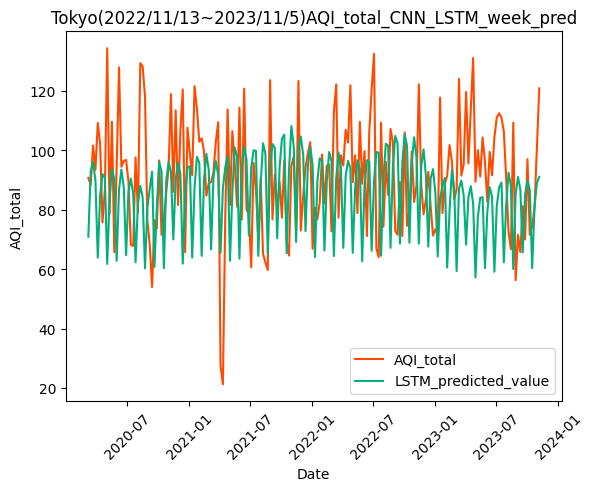

,precipitation,temperature,wind-speed,pressure,humidity,co,so2,pm25,pm10,o3,no2,AQI_total,target,AQI_total_pred_original
Date,,,,,,,,,,,,,,
2020-03-08,2.857143,8.657143,3.114286,1014.285714,69.428571,0.340000,0.00150,35.571429,9.857143,0.023771,0.012214,90.714286,0.527115,70.923516
2020-03-15,7.071429,11.371429,2.971429,1007.000000,71.285714,0.371429,0.00170,34.285714,10.285714,0.024129,0.014071,88.285714,0.508677,93.065826
2020-03-22,0.142857,12.342857,3.471429,1006.314286,51.428571,0.387143,0.00210,40.857143,12.857143,0.029400,0.013929,101.571429,0.609544,96.013897
2020-03-29,8.571429,10.971429,3.500000,1013.200000,63.714286,0.371429,0.00170,37.142857,11.142857,0.028343,0.013429,93.428571,0.547722,89.841509
2020-04-05,4.428571,11.628571,3.214286,1011.842857,68.285714,0.371429,0.00170,44.857143,13.285714,0.027014,0.012629,109.142857,0.667028,63.849638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-08,2.142857,20.585714,2.871429,1010.857143,60.000000,0.340000,0.00150,25.857143,9.714286,0.026671,0.008114,71.571429,0.381779,86.512047
2023-10-15,13.785714,18.057143,2.300000,1011.771429,74.285714,0.371429,0.00150,27.857143,9.285714,0.023014,0.009429,74.285714,0.402386,60.352048
2023-10-22,0.000000,19.200000,2.657143,1010.885714,61.571429,0.371429,0.00150,30.714286,10.142857,0.026314,0.011300,80.714286,0.451193,80.917728


In [ ]:
create_week_model(Tokyo,"Tokyo")

In [ ]:
df_results

,cnn_week_mape,lstm_week_mape
Tokyo_AQI_total,NaN,14.87%


In [ ]:
df_results

,cnn_week_mape,lstm_week_mape
Tokyo_AQI_total,NaN,14.4%
